# Procedure for estimating noise parameters

In [1]:
from matplotlib import pyplot as plt
from matplotlib.figure import figaspect

import numpy as np
from numpy.random import default_rng

import thztools as thz

## Simulate measurements
Simulate a set of `m` waveforms, each sampled at `n` time points, with noise parameters
`sigma_alpha`, `sigma_beta`, and `sigma_tau`, and store them in an array `x`. Note that
`x` stores the waveforms in row orientation, with shape `(m, n)`, because NumPy
broadcasting rules and FFT functions are simpler for arrays that are row-oriented.
Measurement waveforms are typically loaded from data files in column orientation,
however, so the `tdnoisefit` function assumes that the data array is column-oriented—this
may be worth changing in a future version.

In [2]:
n = 256  # Number of samples
m = 50  # Number of waveforms
ts = 0.05  # Sampling time [ps]
t0 = 2.5  # Peak pulse time [ps]
fs = 1 / ts  # Sampling frequency [THz]

sigma_alpha = 1e-4  # Additive noise amplitude [signal units]
sigma_beta = 1e-2  # Multiplicative noise amplitude [dimensionless]
sigma_tau = 1e-3  # Time base noise amplitude [ps]
sigma_parms = np.array([sigma_alpha, sigma_beta, sigma_tau])

seed = 0  # RNG seed
rng = default_rng(seed)

In [3]:
mu, t = thz.thzgen(n, ts, t0)
sigma = thz.noiseamp(sigma_parms, mu, ts)

# Use broadcasting to generate multiple simulated noisy measurements of y
x = mu + sigma * rng.standard_normal((m, n))

## Fit for the noise parameters

Set the initial guesses `a0` and `eta0` for the amplitudes and delays, respectively, and
estimate the noise parameters from the simulated measurements. Note that we must take the
transpose of `x`, to convert it from row-orientation to column-orientation.

In [4]:
# tdnoisefit expects a column-oriented data array
a0 = np.ones(m)
eta0 = np.zeros(m)
result = thz.tdnoisefit(
    x.T, a0=a0, eta0=eta0, ts=ts, fix_a=False, fix_eta=False
)

### Check the variance amplitude estimates

The `tdnoisefit` function returns a tuple with three elements: a dictionary `p` of output
parameters; the value `fval` of the cost function at those parameters; and a dictionary
`diagnostic` that includes additional diagnostic information about the result, including
the parameter uncertainty. Note that noise parameter uncertainty is expressed as a
standard deviation, so the uncertainty in the noise parameters refers to the standard
deviation of the variance amplitude. We apply the Poisson correction to each variance
parameter and its associated uncertainty—that is we multiply each by `m / (m - 1)`.

In [5]:
p_names = ["var_alpha", "var_beta", "var_tau"]
for i in range(3):
    val = result[0]['var'][i] * (m / (m - 1))
    err = result[2]['err']['var'][i] * (m / (m - 1))
    print(f"Estimated {p_names[i]}: {val:.4g} ± {err:.4g}")

Estimated var_alpha: 9.92e-09 ± 3.362e-08
Estimated var_beta: 7.976e-05 ± 0.0001039
Estimated var_tau: 3.268e-06 ± 2.576e-05


### Check the noise amplitude estimates

Compare the noise amplitude estimates with their true values, specified in the
simulation. The noise amplitudes are just the square root of the variance amplitudes,
and propagating the error for the noise amplitude uncertainty yields

$$
\sigma^2_{\sigma_k} = \left(\frac{dV_k}{d\sigma_k}\right)^{-2} \sigma^2_{V_k}
= \frac{1}{2\sigma_k} \sigma^2_{V_k}.
$$

In [6]:
p_names = ["sigma_alpha", "sigma_beta", "sigma_tau"]
for i in range(3):
    val = np.sqrt(result[0]['var'][i] * (m / (m - 1)))
    err = 0.5 * result[2]['err']['var'][i] * (m / (m - 1)) / val
    print(f"Estimated {p_names[i]}: {val:.4g} ± {err:.4g}")
for i in range(3):
    val = np.sqrt(result[0]['var'][i] * (m / (m - 1))) / sigma_parms[i]
    err = (
        0.5
        * result[2]['err']['var'][i]
        * (m / (m - 1))
        / (sigma_parms[i] ** 2)
    )
    print(
        f"Estimated {p_names[i]}, relative to true value: {val:.3f} ± {err:.3f}"
    )

Estimated sigma_alpha: 9.96e-05 ± 0.0001688
Estimated sigma_beta: 0.008931 ± 0.00582
Estimated sigma_tau: 0.001808 ± 0.007125
Estimated sigma_alpha, relative to true value: 0.996 ± 1.681
Estimated sigma_beta, relative to true value: 0.893 ± 0.520
Estimated sigma_tau, relative to true value: 1.808 ± 12.879


## Debug errors encountered in testing
The `TestTDNoiseFit` class is currently unreliable. It returns errors when run in a Mamba environment but does not when run in a Hatch environment. It also exhibits sensitivity to the assumed noise parameters. The cell below reproduces the test data set.

In [24]:
rng = np.random.default_rng(0)
n = 64
m = 8
ts = 1.0 / n
t = np.arange(n) * ts
mu, _ = thz.thzgen(n, ts=ts, t0=n * ts / 2)
sigma = np.array([1e-5, 1e-7, 1e-8])
noise = thz.noiseamp(sigma, mu, ts) * rng.standard_normal((m, n))
x = np.array(mu + noise)
a = np.ones(m)
eta = np.zeros(m)

Plot the data

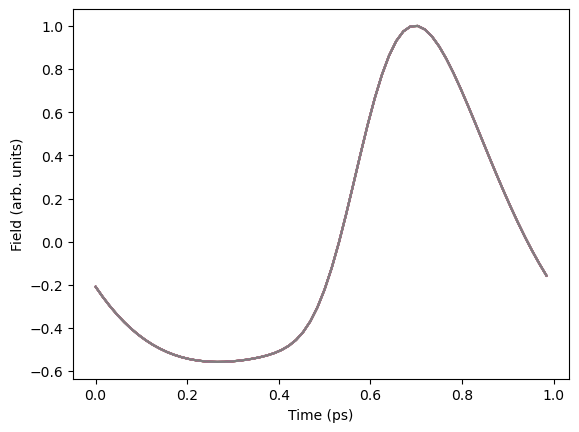

In [25]:
_, ax = plt.subplots()
ax.plot(t, x.T)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Field (arb. units)')
plt.show()

So that appears to be the problem: the waveform is not compact. Adjust the parameters to fix this.

In [38]:
rng = np.random.default_rng(0)
n = 128
m = 8
ts = 0.05
t = np.arange(n) * ts
mu, _ = thz.thzgen(n, ts=ts, t0=n * ts / 3)
sigma = np.array([1e-5, 1e-7, 1e-8])
noise = thz.noiseamp(sigma, mu, ts) * rng.standard_normal((m, n))
x = np.array(mu + noise)
a = np.ones(m)
eta = np.zeros(m)

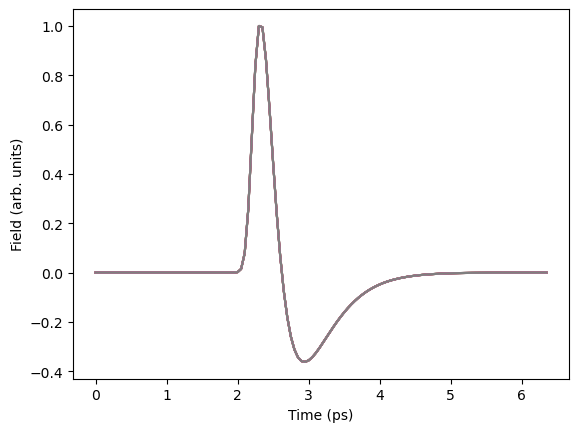

In [39]:
_, ax = plt.subplots()
ax.plot(t, x.T)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Field (arb. units)')
plt.show()

Updated `TestTDNoiseFit` with these changes, leaving `sigma` unchanged. Now, all tests pass in the Mamba environment, but 8 of the tests fail in the Hatch environment! Try setting `sigma` to more realistic values, as indicated by the cells below.

In [40]:
rng = np.random.default_rng(0)
n = 128
m = 8
ts = 0.05
t = np.arange(n) * ts
mu, _ = thz.thzgen(n, ts=ts, t0=n * ts / 3)
sigma = np.array([1e-5, 1e-2, 1e-3])
noise = thz.noiseamp(sigma, mu, ts) * rng.standard_normal((m, n))
x = np.array(mu + noise)
a = np.ones(m)
eta = np.zeros(m)

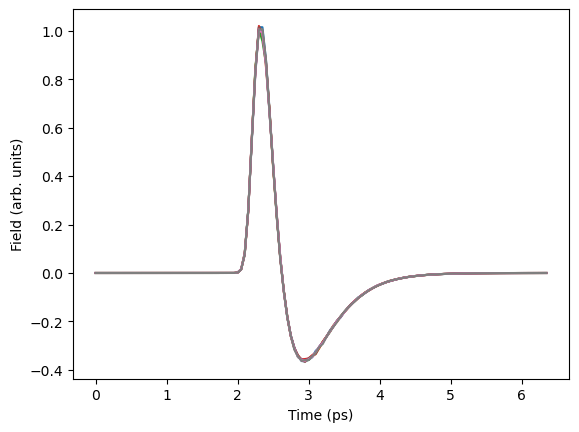

In [41]:
_, ax = plt.subplots()
ax.plot(t, x.T)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Field (arb. units)')
plt.show()

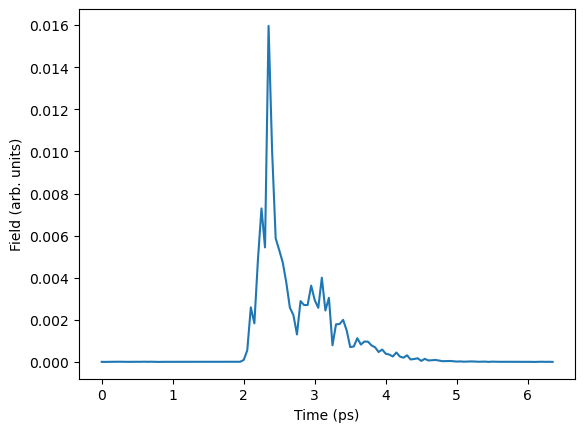

In [42]:
_, ax = plt.subplots()
ax.plot(t, np.std(x, axis=0).T)
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Field (arb. units)')
plt.show()

Now all tests fail in both environments. Progress?

## Review function
Copy the function below and debug the tests individually.

In [48]:
from numpy.typing import ArrayLike
from scipy.optimize import minimize
from thztools import tdnll

NUM_NOISE_PARAMETERS = 3
NUM_NOISE_DATA_DIMENSIONS = 2


def tdnoisefit(
    x: ArrayLike,
    *,
    v0: ArrayLike | None = None,
    mu0: ArrayLike | None = None,
    a0: ArrayLike | None = None,
    eta0: ArrayLike | None = None,
    ts: float = 1.0,
    fix_v: bool = False,
    fix_mu: bool = False,
    fix_a: bool = True,
    fix_eta: bool = True,
) -> tuple[dict, float, dict]:
    r"""
    Compute time-domain noise model parameters.

    Computes the noise parameters sigma and the underlying signal vector ``mu``
    for the data matrix ``x``, where the columns of ``x`` are each noisy
    measurements of ``mu``.

    Parameters
    ----------
    x : ndarray
        Data array.
    v0 : ndarray, optional
        Initial guess, noise model parameters with size (3,), expressed as
        variance amplitudes.
    mu0 : ndarray, optional
        Initial guess, signal vector with size (n,).
    a0 : ndarray, optional
        Initial guess, amplitude vector with size (m,).
    eta0 : ndarray, optional
        Initial guess, delay vector with size (m,).
    ts : float, optional
        Sampling time
    fix_v : bool, optional
        Noise variance parameters.
    fix_mu : bool, optional
        Signal vector.
    fix_a : bool, optional
        Amplitude vector.
    fix_eta : bool, optional
        Delay vector.

    Returns
    --------
    p : dict
        Output parameter dictionary containing:
            var : ndarray
                Noise parameters, expressed as variance amplitudes.
            mu : ndarray
                Signal vector.
            a : ndarray
                Amplitude vector.
            eta : ndarray
                Delay vector.
    fval : float
        Value of NLL cost function from FMINUNC
    Diagnostic : dict
        Dictionary containing diagnostic information
            err : dic
                Dictionary containing  error of the parameters.
            grad : ndarray
                Negative loglikelihood cost function gradient from
                scipy.optimize.minimize BFGS method.
            hessian : ndarray
                Negative loglikelihood cost function hessian from
                scipy.optimize.minimize BFGS method.
    """
    if fix_v and fix_mu and fix_a and fix_eta:
        msg = "All variables are fixed"
        raise ValueError(msg)
    # Parse and validate function inputs
    x = np.asarray(x)
    if x.ndim != NUM_NOISE_DATA_DIMENSIONS:
        msg = "Data array x must be 2D"
        raise ValueError(msg)
    n, m = x.shape

    if v0 is None:
        v0 = np.mean(np.var(x, 1)) * np.ones(NUM_NOISE_PARAMETERS)
    else:
        v0 = np.asarray(v0)
        if v0.size != NUM_NOISE_PARAMETERS:
            msg = (
                "Noise parameter array logv must have "
                f"{NUM_NOISE_PARAMETERS} elements."
            )
            raise ValueError(msg)

    if mu0 is None:
        mu0 = np.mean(x, 1)
    else:
        mu0 = np.asarray(mu0)
        if mu0.size != n:
            msg = "Size of mu0 is incompatible with data array x."
            raise ValueError(msg)

    if a0 is None:
        a0 = np.ones(m)
    else:
        a0 = np.asarray(a0)
        if a0.size != m:
            msg = "Size of a0 is incompatible with data array x."
            raise ValueError(msg)

    if eta0 is None:
        eta0 = np.zeros(m)
    else:
        eta0 = np.asarray(eta0)
        if eta0.size != m:
            msg = "Size of eta0 is incompatible with data array x."
            raise ValueError(msg)

    # Set initial guesses for all free parameters
    x0 = np.array([])
    if not fix_v:
        # Replace log(x) with -inf when x <= 0
        logv0 = np.ma.log(v0).filled(-np.inf)
        x0 = np.concatenate((x0, logv0))
    if not fix_mu:
        x0 = np.concatenate((x0, mu0))
    if not fix_a:
        x0 = np.concatenate((x0, a0[1:] / a0[0]))
    if not fix_eta:
        x0 = np.concatenate((x0, eta0[1:] - eta0[0]))

    # Bundle free parameters together into objective function
    def objective(_p):
        if fix_v:
            _logv = np.ma.log(v0).filled(-np.inf)
        else:
            _logv = _p[:3]
            _p = _p[3:]
        if fix_mu:
            _mu = mu0
        else:
            _mu = _p[:n]
            _p = _p[n:]
        if fix_a:
            _a = a0
        else:
            _a = np.concatenate((np.array([1.0]), _p[: m - 1]))
            _p = _p[m - 1 :]
        if fix_eta:
            _eta = eta0
        else:
            _eta = np.concatenate((np.array([0.0]), _p[: m - 1]))
        return tdnll(
            x.T,
            _mu,
            _logv,
            _a,
            _eta,
            ts,
            fix_logv=fix_v,
            fix_mu=fix_mu,
            fix_a=fix_a,
            fix_eta=fix_eta,
        )

    # Minimize cost function with respect to free parameters
    out = minimize(objective, x0, method="L-BFGS-B", jac=True)

    # Parse output
    p = {}
    x_out = out.x
    if fix_v:
        p["var"] = v0
    else:
        p["var"] = np.exp(x_out[:3])
        x_out = x_out[3:]

    if fix_mu:
        p["mu"] = mu0
    else:
        p["mu"] = x_out[:n]
        x_out = x_out[n:]

    if fix_a:
        p["a"] = a0
    else:
        p["a"] = np.concatenate(([1], x_out[: m - 1]))
        x_out = x_out[m - 1 :]

    if fix_eta:
        p["eta"] = eta0
    else:
        p["eta"] = np.concatenate(([0], x_out[: m - 1]))

    p["ts"] = ts

    diagnostic = {
        "grad": out.jac,
        "cov": out.hess_inv.matmat(np.eye(out.hess_inv.shape[0])),
        "err": {
            "var": np.array([]),
            "mu": np.array([]),
            "a": np.array([]),
            "eta": np.array([]),
        },
        "success": out.success,
        "status": out.status,
        "message": out.message,
        "nfev": out.nfev,
        "njev": out.njev,
        "nit": out.nit,
    }
    err = np.sqrt(np.diag(diagnostic["cov"]))
    if not fix_v:
        # Propagate error from log(V) to V
        diagnostic["err"]["var"] = np.sqrt(
            np.diag(np.diag(p["var"]) @ diagnostic["cov"][0:3, 0:3])
            @ np.diag(p["var"])
        )
        err = err[3:]

    if not fix_mu:
        diagnostic["err"]["mu"] = err[:n]
        err = err[n:]

    if not fix_a:
        diagnostic["err"]["a"] = np.concatenate(([0], err[: m - 1]))
        err = err[m - 1 :]

    if not fix_eta:
        diagnostic["err"]["eta"] = np.concatenate(([0], err[: m - 1]))

    return p, out.fun, diagnostic

When run with default values for everything, the fit converges but to inaccurate values.

In [51]:
p, fval, diagnostic = tdnoisefit(x.T)

In [52]:
p["var"] * m / (m - 1)

array([5.70721119e-09, 5.14966456e-05, 6.72986802e-06])

In [53]:
sigma**2

array([1.e-10, 1.e-04, 1.e-06])

Try varyiung `n` and `m`.

In [54]:
rng = np.random.default_rng(0)
n = 256
m = 64
ts = 0.05
t = np.arange(n) * ts
mu, _ = thz.thzgen(n, ts=ts, t0=n * ts / 3)
sigma = np.array([1e-5, 1e-2, 1e-3])
noise = thz.noiseamp(sigma, mu, ts) * rng.standard_normal((m, n))
x = np.array(mu + noise)
a = np.ones(m)
eta = np.zeros(m)

In [55]:
p, fval, diagnostic = tdnoisefit(x.T)

In [56]:
p["var"] * m / (m - 1)

array([9.56491352e-11, 1.19753065e-04, 4.98771399e-06])

In [60]:
diagnostic["message"]

'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'

Commented out the `assert_allclose` lines in `test_thztools` and encountered 52 errors with the Hatch environment and 48 with the Mamba environment. When I reviewed them, it looks like some tests are failing in Hatch but not in Mamba, and vice versa.

After reviewing the errors returned in the Mamba environment, they all result from exceeding the evaluation limit. Reducing `ftol` is enough to solve that problem.

Tried to reduce `atol` and `rtol` in the `assert_allclose` statement, but all of these occur when `fix_v = False`.